In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import sys

sys.path.append("../")

In [107]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [108]:
# !pip install torchmetrics

In [109]:
from torchmetrics.classification import Accuracy, CalibrationError


def calculate_accuracy(predictions, labels):
    accuracy_metric = Accuracy(task="multiclass", num_classes=4)
    
    predictions_tensor = torch.tensor(predictions)
    labels_tensor = torch.tensor(labels)
    
    accuracy = accuracy_metric(predictions_tensor, labels_tensor)
    
    return accuracy.item()

def calculate_ece(predictions, labels, n_bins=10):
    ece_metric = CalibrationError(n_bins=n_bins, norm='l1', task="multiclass", num_classes=4)
    
    predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
    labels_tensor = torch.tensor(labels)
    
    ece = ece_metric(predictions_tensor, labels_tensor)
    
    return ece.item()

# Load model

In [110]:
import torch
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM

# model_id = "meta-llama/Meta-Llama-3-8B"
# model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_id = "huggyllama/llama-7b"
# model_id = "facebook/opt-13b"
model_id = "meta-llama/Llama-2-7b-hf"


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    output_hidden_states=True,
    device_map="auto",
    torch_dtype=torch.float16,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load dataset

Please pick one among the available configs: 
['abstract_algebra', 'all', 'anatomy', 'astronomy', 'auxiliary_train', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cais/mmlu", "high_school_us_history")

In [ ]:
dataset["test"][0]

{'question': 'This question refers to the following information.\n"The far-reaching, the boundless future will be the era of American greatness. In its magnificent domain of space and time, the nation of many nations is destined to manifest to mankind the excellence of divine principles; to establish on earth the noblest temple ever dedicated to the worship of the Most High—the Sacred and the True. Its floor shall be a hemisphere—its roof the firmament of the star-studded heavens, and its congregation a Union of many Republics, comprising hundreds of happy millions, calling, owning no man master, but governed by God\'s natural and moral law of equality, the law of brotherhood—of \'peace and good will amongst men.\'"\nJohn L. O\'Sullivan, "The Great Nation of Futurity," 1839\nBy what means did the United States take possession of the Oregon Territory?',
 'subject': 'high_school_us_history',
 'choices': ['The United States was granted the territory in a postwar treaty with France.',
  'T

In [ ]:
def create_prompt(example):
    question = example['question']
    choices = example['choices']
    
    prompt = f"Question: {question}\n\n"
    prompt += "Choices:\n"
    
    for i, choice in enumerate(choices, start=1):
        prompt += f"{chr(64 + i)}. {choice}\n"
    
    prompt += "\nAnswer:"
    
    return prompt

In [ ]:
print(create_prompt(dataset["test"][0]))

Question: This question refers to the following information.
"The far-reaching, the boundless future will be the era of American greatness. In its magnificent domain of space and time, the nation of many nations is destined to manifest to mankind the excellence of divine principles; to establish on earth the noblest temple ever dedicated to the worship of the Most High—the Sacred and the True. Its floor shall be a hemisphere—its roof the firmament of the star-studded heavens, and its congregation a Union of many Republics, comprising hundreds of happy millions, calling, owning no man master, but governed by God's natural and moral law of equality, the law of brotherhood—of 'peace and good will amongst men.'"
John L. O'Sullivan, "The Great Nation of Futurity," 1839
By what means did the United States take possession of the Oregon Territory?

Choices:
A. The United States was granted the territory in a postwar treaty with France.
B. The United States bought it from the Native Americans w

# Approach 1: Calculating Log-Probabilities of generated text

In [ ]:
# import re

# def answer_question_with_confidence(prompt: str, device: str | torch.device = torch.device("cuda")):
#     input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

#     output_sequences = model.generate(input_ids, max_length=len(input_ids[0]) + 3, num_return_sequences=1, output_scores=True, return_dict_in_generate=True, pad_token_id=tokenizer.eos_token_id)

#     generated_tokens = output_sequences.sequences[0]
#     generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

#     logits = torch.stack(output_sequences.scores, dim=1)
#     logprobs = torch.nn.functional.log_softmax(logits, dim=-1)

#     generated_token_ids = generated_tokens[len(input_ids[0]):].unsqueeze(-1)
#     generated_token_logprobs = logprobs.squeeze(0).gather(1, generated_token_ids).squeeze(-1)

#     confidence_score = generated_token_logprobs.exp().mean().item()

#     pattern = r'Answer:\s*([A-D])'
#     match = re.search(pattern, generated_text, re.IGNORECASE)
#     if match:
#         answer = match.group(1).lower()
#         label = ord(answer) - ord('a')
#     else:
#         answer = None
#         print("No answer found.")

#     if answer is not None:
#         return label, confidence_score, generated_text
#     else:
#         return None, None, generated_text

In [ ]:
from tqdm import tqdm

generated_texts = []
labels = []
probs = []
gts = []

for example in tqdm(dataset["test"]):
    prompt = create_prompt(example)
    label, confidence_score, generated_text = answer_question_with_confidence(prompt)
    generated_texts.append(generated_text)
    labels.append(label)
    probs.append(confidence_score)
    gts.append(example["answer"])


  1%|          | 2/204 [00:00<00:40,  5.01it/s]

No answer found.


  3%|▎         | 7/204 [00:01<00:28,  6.92it/s]

No answer found.


  6%|▋         | 13/204 [00:01<00:25,  7.38it/s]

No answer found.


  9%|▉         | 19/204 [00:02<00:26,  6.92it/s]

No answer found.


 12%|█▏        | 25/204 [00:03<00:24,  7.24it/s]

No answer found.


 22%|██▏       | 45/204 [00:06<00:23,  6.75it/s]

No answer found.


 24%|██▎       | 48/204 [00:06<00:21,  7.27it/s]

No answer found.


 29%|██▉       | 60/204 [00:08<00:20,  6.91it/s]

No answer found.


 37%|███▋      | 76/204 [00:10<00:17,  7.28it/s]

No answer found.


 42%|████▏     | 85/204 [00:12<00:15,  7.54it/s]

No answer found.


 48%|████▊     | 98/204 [00:14<00:15,  6.97it/s]

No answer found.


KeyboardInterrupt: 

In [ ]:
calculate_accuracy(labels, gts)

0.720588207244873

In [ ]:
calculate_ece(probs, labels)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# Approach 2: Calculating Log-Probabilities for All Answer Choices (to get ECE)

In [113]:
import re
import numpy as np

def answer_question_with_confidence(prompt, device = "cuda", use_probs = True, top_k = 100):
    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]

    probabilities = torch.softmax(logits, dim=-1)
    top_k_probs, top_k_tokens = torch.topk(probabilities, top_k)

    # aggregate probabilities for each choice
    choice_probabilities = {
        'A': 0.0,
        'B': 0.0,
        'C': 0.0,
        'D': 0.0,
    }
    valid_tokens = {
        'A': ["A", "A."],
        'B': ["B", "B."],
        'C': ["C", "C."],
        'D': ["D", "D."],
    }

    # decode tokens and aggregate probabilities
    for token, prob in zip(top_k_tokens, top_k_probs):
        token_str = tokenizer.decode([token]).strip()
        for choice, valid_list in valid_tokens.items():
            if token_str in valid_list:
                choice_probabilities[choice] += prob.item()
                break

    # normalize 
    total_sum = sum(choice_probabilities.values())
    normalized_probabilities = {choice: prob / total_sum for choice, prob in choice_probabilities.items()}

    # for choice, agg_prob in normalized_probabilities.items():
    #     print(f"Aggregated normalized probability of choosing '{choice}': {agg_prob:.4f}")

    conf = list(normalized_probabilities.values())
    label = np.argmax(conf)

    return label, conf

In [ ]:
from tqdm import tqdm

labels = []
probs = []
gts = []

for example in tqdm(dataset["test"]):
    prompt = create_prompt(example)
    label, conf = answer_question_with_confidence(prompt)
    labels.append(label)
    probs.append(conf)
    gts.append(example["answer"])


100%|██████████| 204/204 [00:16<00:00, 12.46it/s]


In [ ]:
acc = calculate_accuracy(labels, gts)
acc

0.45098039507865906

In [ ]:
ece = calculate_ece(probs, labels)
ece

0.6508091688156128

In [ ]:
arr_probs = np.array(probs)

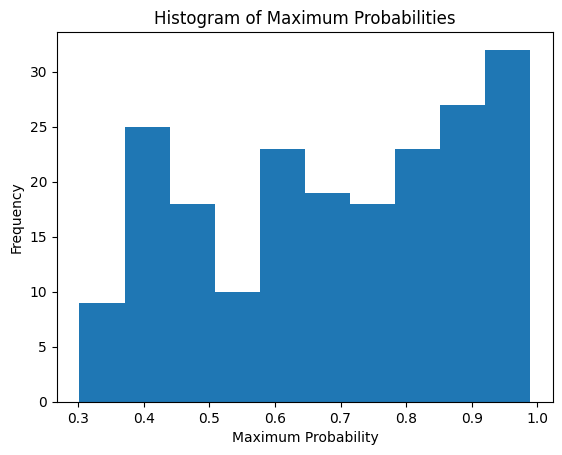

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.max(arr_probs, axis=1))
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Probabilities')
plt.show()


# np.max(arr_probs, axis=1)

## Calibration curve

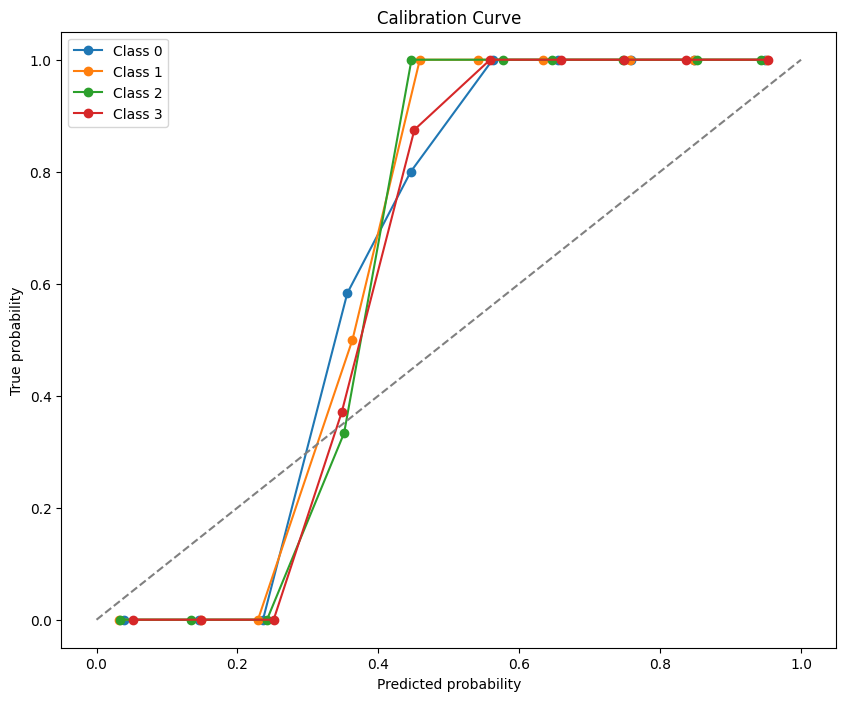

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(10, 8))


y_bin = label_binarize(np.array(labels), classes=[0, 1, 2, 3])

for i in range(y_bin.shape[1]):
    prob_true, prob_pred = calibration_curve(y_bin[:, i], np.array(probs)[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()


# Entropy

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 204
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 22
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 5
    })
})

In [ ]:
dataset["test"][0]

{'question': 'This question refers to the following information.\n"The far-reaching, the boundless future will be the era of American greatness. In its magnificent domain of space and time, the nation of many nations is destined to manifest to mankind the excellence of divine principles; to establish on earth the noblest temple ever dedicated to the worship of the Most High—the Sacred and the True. Its floor shall be a hemisphere—its roof the firmament of the star-studded heavens, and its congregation a Union of many Republics, comprising hundreds of happy millions, calling, owning no man master, but governed by God\'s natural and moral law of equality, the law of brotherhood—of \'peace and good will amongst men.\'"\nJohn L. O\'Sullivan, "The Great Nation of Futurity," 1839\nBy what means did the United States take possession of the Oregon Territory?',
 'subject': 'high_school_us_history',
 'choices': ['The United States was granted the territory in a postwar treaty with France.',
  'T

In [ ]:
from src.matrix_entropy import compute_entropies_for_each_sentence
from torch.utils.data import DataLoader

def get_dataloader(dataset, target_column, remove_columns, max_length=2048, seed=42):
    def tokenize_function(examples):
        return tokenizer(examples[target_column], truncation=True, max_length=max_length)

    tokenized_dataset = dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
    tokenized_dataset = tokenized_dataset.remove_columns(remove_columns)
    tokenized_dataset.set_format("torch")

    dataloader = DataLoader(tokenized_dataset, shuffle=False)
    return dataloader

remove_columns = ["question", "subject", "choices", "answer"]
target_column = "question"

dataloader = get_dataloader(dataset["test"], target_column, remove_columns)


In [ ]:
for batch in dataloader:
    break


In [ ]:
entropies = compute_entropies_for_each_sentence(
    model, dataloader, alpha=1, device=device
)

100%|██████████| 204/204 [01:04<00:00,  3.15it/s]


In [ ]:
from plots import get_metric

es = []

for hs in entropies["unnormalized_entropy"].keys():
    es.append(np.mean(get_metric(entropies, "logD_normalized_entropy", hidden_state=hs)))

In [ ]:
ece

0.6508091688156128

In [ ]:
acc

0.45098039507865906

In [ ]:
es

[0.5599139599674448,
 0.5255971216936917,
 0.030733626266774762,
 0.058758139308885404,
 0.10217346937515606,
 0.15820767365748076,
 0.2103529254196467,
 0.25443197496472686,
 0.29358505595616385,
 0.3294255891732679,
 0.36089889060566077,
 0.3891637121916961,
 0.407807922398667,
 0.42962054888973905,
 0.45257027436620073,
 0.47512650564511877,
 0.4986763215158493,
 0.5186891094504077,
 0.5320056197416279,
 0.544766583636933,
 0.5550247929084757,
 0.5594047134368744,
 0.5647375122729006,
 0.567248323665618,
 0.5724634845418408,
 0.573287191373396,
 0.5782040734927548,
 0.5795444156454671,
 0.5834706753072084,
 0.5851721998548984,
 0.5879367234544791,
 0.5928850838787854,
 0.5452064233651492]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(calibration_errors, accuracies, entropies):
    """
    Plots calibration errors, accuracies, and entropies for different hidden states.
    
    Args:
    calibration_errors (list of float): The calibration errors.
    accuracies (list of float): The accuracies.
    entropies (list of float): The entropies for different hidden states.
    """
    
    # Create a figure with subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 3]})

    # Scatter plot for calibration errors and accuracies
    ax[0].scatter(accuracies, calibration_errors, color='blue', marker='o')
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Value')
    ax[0].set_title('Calibration Errors and Accuracies')
    ax[0].legend()

    # Line plot for entropies
    ax[1].plot(entropies, marker='o')
    ax[1].set_xlabel('Hidden State')
    ax[1].set_ylabel('Entropy')
    ax[1].set_title('Entropies for Different Hidden States')

    # Customize the appearance
    sns.despine()
    plt.tight_layout()
    plt.show()


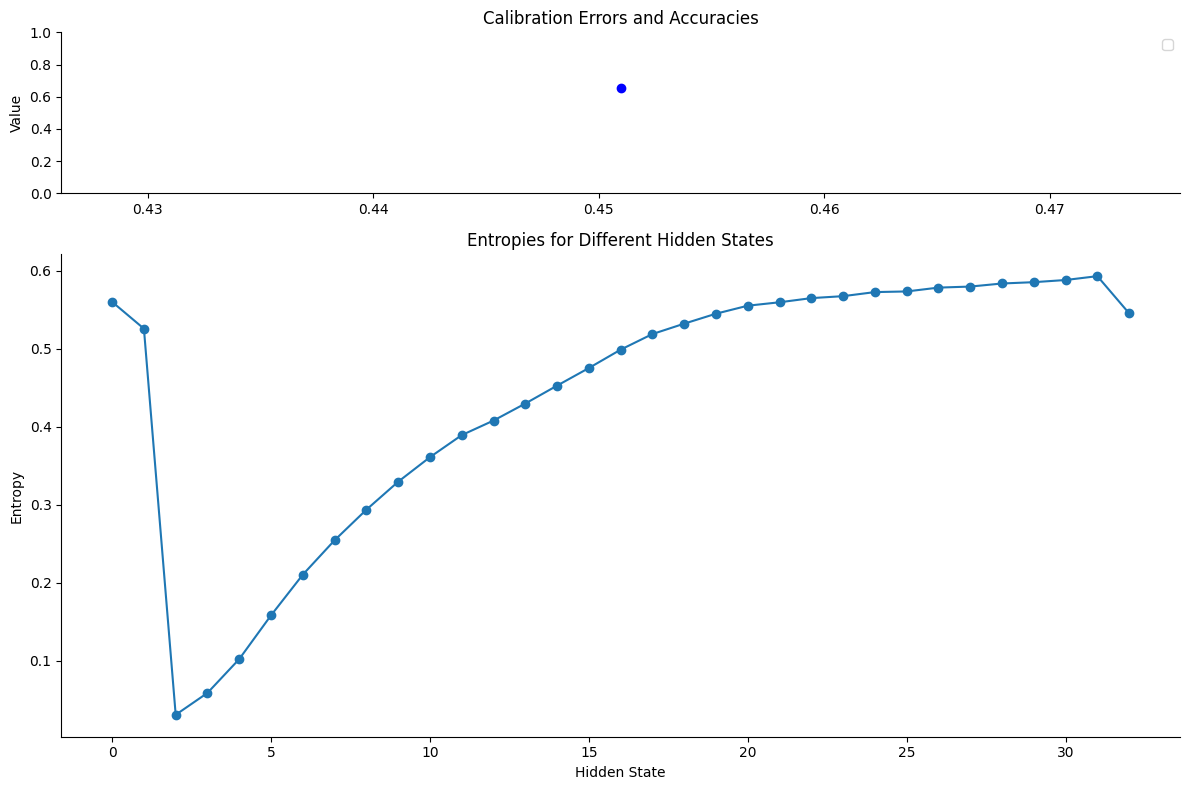

In [ ]:
plot_metrics([ece], [acc], es)

# Run experiments for different models and datasets

In [114]:
from src.matrix_entropy import compute_entropies_for_each_sentence
from torch.utils.data import DataLoader
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
from plots import get_metric
import json

def get_dataloader(dataset, target_column, remove_columns, max_length=2048, seed=42):
    def tokenize_function(examples):
        return tokenizer(examples[target_column], truncation=True, max_length=max_length)

    tokenized_dataset = dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
    tokenized_dataset = tokenized_dataset.remove_columns(remove_columns)
    tokenized_dataset.set_format("torch")

    dataloader = DataLoader(tokenized_dataset, shuffle=False)
    return dataloader



In [158]:
EXP_MODELS = ['meta-llama/Llama-2-7b-hf', 'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-13b-hf', 'meta-llama/Llama-2-13b-chat-hf']
EXP_DATASETS = ['high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history']

# ['business_ethics', 'elementary_mathematics', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'sociology', 'us_foreign_policy']



results = []

for model_id in EXP_MODELS:
    print(model_id)
    for dataset_id in EXP_DATASETS:
        print(dataset_id)
        dataset = load_dataset('cais/mmlu', dataset_id)
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            output_hidden_states=True,
            device_map="auto",
            torch_dtype=torch.float16,
        )

        labels = []
        probs = []
        gts = []
        for example in tqdm(dataset["test"]):
            prompt = create_prompt(example)
            label, conf = answer_question_with_confidence(prompt)
            labels.append(label)
            probs.append(conf)
            gts.append(example["answer"])
        acc = calculate_accuracy(labels, gts)
        ece = calculate_ece(probs, labels)

        remove_columns = ["question", "subject", "choices", "answer"]
        target_column = "question"
        dataloader = get_dataloader(dataset["test"], target_column, remove_columns)
        entropies = compute_entropies_for_each_sentence(
            model, dataloader, alpha=1, device=device
        )
        es = []
        for hs in entropies["unnormalized_entropy"].keys():
            es.append(np.mean(get_metric(entropies, "logD_normalized_entropy", hidden_state=hs)))

        results.append({
            'model': model_id,
            'dataset': dataset_id,
            'acc': acc,
            'ece': ece,
            'es': es,
            'labels': np.array(labels).tolist(), # avoid int64 json serialization issue
            'probs': probs,
            'gts': gts,
            'entropies': entropies
        })
        # save results to json
        with open(f'results-{model_id.replace("/", "_")}-mmlu_{dataset_id}.json', 'w') as f:
            json.dump(results, f)


meta-llama/Llama-2-7b-hf
high_school_biology


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 310/310 [00:18<00:00, 16.84it/s]


In [159]:
# save results to json
with open(f'results-{model_id.replace("/", "_")}-mmlu_{dataset_id}.json', 'w') as f:
    json.dump(results, f)

In [128]:
f'results-{model_id.replace("/", "_")}-mmlu_{dataset_id}.json'

'results-meta-llama_Llama-2-7b-hf-mmlu_high_school_biology.json'

In [127]:
# save results to json
with open(f'results-{model_id.replace("/", "_")}-mmlu_{dataset_id}.json', 'w') as f:
    json.dump(results, f)

TypeError: Object of type int64 is not JSON serializable

In [121]:
results[0].keys()

dict_keys(['model', 'dataset', 'acc', 'ece', 'es', 'labels', 'probs', 'gts', 'entropies'])

In [125]:
del results[0]["entropies"]

In [131]:
results[0].keys()

dict_keys(['model', 'dataset', 'acc', 'ece', 'es', 'labels', 'probs', 'gts'])

In [133]:
for k in results[0].keys():
    print(k, type(results[0][k]))

model <class 'str'>
dataset <class 'str'>
acc <class 'float'>
ece <class 'float'>
es <class 'list'>
labels <class 'list'>
probs <class 'list'>
gts <class 'list'>


In [149]:
type(results[0]["labels"][0])

numpy.int64

In [156]:
np.array(results[0]["labels"]).tolist()

int

---
# Other solutions

In [ ]:
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer

prompt = """Question: Who was the first president of the United States? 

### 

Choices:
A. Barack Obama
B. George Washington
C. Michael Jackson
D. None of the above

###

Answer: """

inputs = tokenizer(prompt, return_tensors='pt').to('cuda')

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits[0, -1, :]

top_k = 100


probabilities = torch.softmax(logits, dim=-1)
top_k_probs, top_k_tokens = torch.topk(probabilities, top_k)


# aggregate probabilities for each choice
choice_probabilities = {
    'A': 0.0,
    'B': 0.0,
    'C': 0.0,
    'D': 0.0,
}
valid_tokens = {
    'A': ["A", "A."],
    'B': ["B", "B."],
    'C': ["C", "C."],
    'D': ["D", "D."],
}

# decode tokens and aggregate probabilities
for token, prob in zip(top_k_tokens, top_k_probs):
    token_str = tokenizer.decode([token]).strip()
    for choice, valid_list in valid_tokens.items():
        if token_str in valid_list:
            choice_probabilities[choice] += prob.item()
            break

# normalize 
total_sum = sum(choice_probabilities.values())
normalized_probabilities = {choice: prob / total_sum for choice, prob in choice_probabilities.items()}

for choice, agg_prob in normalized_probabilities.items():
    print(f"Aggregated normalized probability of choosing '{choice}': {agg_prob:.4f}")

conf = list(normalized_probabilities.values())
label = np.argmax(conf)

# print label and conf
print(f"Predicted label: {label}, Confidence: {max(conf):.4f}")

# for token, prob in zip(top_k_tokens, top_k_probs):
#     print(f"Token: {tokenizer.decode([token]).strip()}, Probability: {prob.item():.4f}")


Aggregated normalized probability of choosing 'A': 0.0257
Aggregated normalized probability of choosing 'B': 0.9297
Aggregated normalized probability of choosing 'C': 0.0120
Aggregated normalized probability of choosing 'D': 0.0327
Predicted label: 1, Confidence: 0.9297


In [ ]:
# apply softmax on values from choice_probabilities dict
import torch.nn.functional as F

torch.tensor(list(choice_probabilities.values()))

tensor([0.0083, 0.2928, 0.0039, 0.0103])

In [ ]:
total_sum = sum(choice_probabilities.values())
normalized_probabilities = {choice: prob / total_sum for choice, prob in choice_probabilities.items()}

print(normalized_probabilities)


{'A': 0.026428683995356094, 'B': 0.9286098642310763, 'C': 0.012279940257722374, 'D': 0.032681511515845224}


In [ ]:
torch.distributions.Categorical(torch.tensor(list(choice_probabilities.values()))).probs

tensor([0.0264, 0.9286, 0.0123, 0.0327])

In [ ]:
F.softmax(torch.tensor(list(choice_probabilities.values())), dim=0)

tensor([8.0133e-06, 9.9997e-01, 1.1016e-06, 1.8632e-05])

# Good solution (shiftting tokens one left to get next token probs)

In [ ]:
import torch
import numpy as np


# Define the prompt and choices
prompt = """Question: Who was the first president of the United States? 

### 

Choices:
A. Barack Obama
B. George Washington
C. Michael Jackson
D. None of the above

###

Answer:"""

choices = ["A. Barack Obama", "B. George Washington", "C. Michael Jackson", "D. None of the above"]


# Tokenize the prompt without the answer
prompt_tokens = tokenizer(prompt, return_tensors='pt').to("cuda")

# Function to calculate log-probability of a choice
def calculate_log_prob(prompt_tokens, choice):
    # Tokenize the full input (prompt + choice)
    choice_tokens = tokenizer(choice, return_tensors='pt').to("cuda")
    full_input_ids = torch.cat((prompt_tokens['input_ids'], choice_tokens['input_ids'][:, 1:]), dim=1)
    
    # Get model output
    with torch.no_grad():
        outputs = model(input_ids=full_input_ids)
    
    # Get logits and calculate log-probabilities for the choice tokens
    logits = outputs.logits[0, prompt_tokens['input_ids'].shape[1]-1:-1, :]  # Only the logits for the choice tokens
    print(logits.shape)

    log_probs = torch.log_softmax(logits, dim=-1)
    
    # Calculate the total log-probability for the choice
    total_log_prob = 0
    for i, token in enumerate(choice_tokens['input_ids'][0, 1:]):
        total_log_prob += log_probs[i, token].item()
    
    return total_log_prob

# Calculate log-probabilities for each choice
log_probs = [calculate_log_prob(prompt_tokens, choice) for choice in choices]

# Print the log-probabilities
for choice, log_prob in zip(choices, log_probs):
    print(f"Log-probability of '{choice}': {log_prob:.4f}")

# Generate the answer to check which choice the model generates
inputs = tokenizer(prompt, return_tensors='pt').to("cuda")
outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
generated_tokens = outputs.sequences[0, inputs.input_ids.shape[1]:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
print(f"Generated answer: {generated_text}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([4, 128256])
torch.Size([4, 128256])
torch.Size([4, 128256])
torch.Size([6, 128256])
Log-probability of 'A. Barack Obama': -19.7893
Log-probability of 'B. George Washington': -15.1474
Log-probability of 'C. Michael Jackson': -20.5238
Log-probability of 'D. None of the above': -20.0082
Generated answer:  B
